In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from PIL import Image

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers  import Dense, Dropout, Flatten, Conv2D,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras import utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)

%matplotlib inline

In [8]:
# Directory paths
train_dir = "../input/chest_xray_3classes/chest_xray/train"
val_dir = "../input/chest_xray_3classes/chest_xray/val"
test_dir = "../input/chest_xray_3classes/chest_xray/test"

In [9]:
# InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

model = Sequential()

model.add(InceptionV3(include_top = False,
                      weights = 'imagenet',
                      input_shape=(150,150,3)))

# Dropout
model.add(Dropout(0.5))

# Pooling layer
model.add(GlobalAveragePooling2D())

# Dense layer
model.add(Dense(128, 
                activation = "relu"))

# Batch Normalizer
model.add(BatchNormalization())

# Output layer
model.add(Dense(3,
                activation = "softmax"))

#Load weights 
model.load_weights("../output/3classes_inception_model.h5")


In [10]:
# check size
model.input, model.output

(<tf.Tensor 'inception_v3_input:0' shape=(None, 150, 150, 3) dtype=float32>,
 <tf.Tensor 'dense_1/Identity:0' shape=(None, 3) dtype=float32>)

In [11]:
# Input shape
model.input_shape[1:3]

(150, 150)

In [12]:
# Data Generator 

#Defining image augmentation
train_idg = ImageDataGenerator(rescale = 1./255,
                               zoom_range = 0.2,
                               shear_range = 0.2,
                               rotation_range = 20,
                               horizontal_flip = True)

test_idg = ImageDataGenerator(rescale = 1./255)

#Creating data loaders
train_gen = train_idg.flow_from_directory(train_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16, #8,16,32
                                    shuffle = True)

val_gen =  test_idg.flow_from_directory(val_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16, 
                                    shuffle = True)

test_gen = test_idg.flow_from_directory(test_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 8,
                                    shuffle = False)

Found 5216 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [13]:
# Predicted classes - Predicted Positives and Predicted Negatives 
predictions = model.predict(test_gen)
pred_0 = predictions[:,0]
pred_1 = predictions[:,1]
pred_2 = predictions[:,2]
predicted_classes = np.argmax(predictions,axis=1)

# True classes - True Positives and True Negatives 
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys()) 

In [14]:
# Create Report
report = metrics.classification_report(true_classes, 
                                       predicted_classes, 
                                       target_names = class_labels)
print(report)  

              precision    recall  f1-score   support

    BACTERIA       0.85      0.95      0.90       242
      NORMAL       0.95      0.82      0.88       234
       VIRUS       0.75      0.77      0.76       148

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.84       624
weighted avg       0.86      0.86      0.86       624



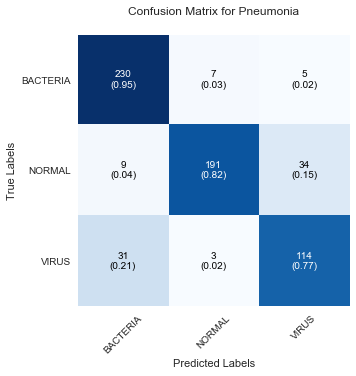

In [17]:
# Create Confusion Matrix
plt.style.use('seaborn')
cm = metrics.confusion_matrix(true_classes,predicted_classes)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5),
                                class_names = class_labels,
                                show_normed = True)
ax.set(title = "Confusion Matrix for Pneumonia",
       ylabel = "True Labels",
       xlabel = "Predicted Labels")
plt.show()

In [19]:
import copy

true_classes0 = copy.deepcopy(true_classes)
true_classes0[true_classes==0]=1
true_classes0[true_classes!=0]=0


true_classes1 = copy.deepcopy(true_classes)
true_classes1[true_classes==1]=1
true_classes1[true_classes!=1]=0


true_classes2 = copy.deepcopy(true_classes)
true_classes2[true_classes==2]=1
true_classes2[true_classes!=2]=0

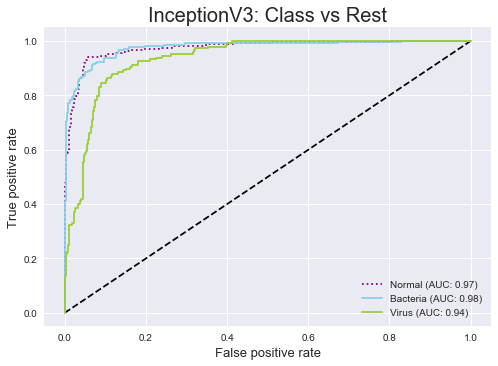

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr0, tpr0, _ = roc_curve(true_classes0, pred_0)
fpr1, tpr1, _ = roc_curve(true_classes1, pred_1)
fpr2, tpr2, _ = roc_curve(true_classes2, pred_2)


# ROC curve graph for all models

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr0, tpr0, label='Normal (AUC: %0.2f)'
             % auc(fpr0,tpr0), color= "purple",  linestyle=':')
plt.plot(fpr1, tpr1, label='Bacteria (AUC: %0.2f)'
             % auc(fpr1,tpr1), color = "skyblue")
plt.plot(fpr2, tpr2, label='Virus (AUC: %0.2f)'
             % auc(fpr2,tpr2), color = "yellowgreen")
plt.xlabel('False positive rate', fontsize = 13)
plt.ylabel('True positive rate', fontsize = 13)
plt.title('InceptionV3: Class vs Rest', fontsize = 20)
plt.legend(loc='best')
plt.show()

source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html